<a href="https://colab.research.google.com/github/Aayushktyagi/DeepLearning_Resources/blob/master/VaeSN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.transform import rescale, resize
from tqdm import tqdm
import cv2
import random

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [ ]:
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras.layers import concatenate, add
from keras.models import Sequential, Model
from keras.layers import Input
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import MaxPool2D, AvgPool2D
from keras.layers import UpSampling2D
# from tensorflow.keras.layers.advanced_activations import LeakyReLU
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Lambda
from keras.layers import MaxPooling2D, GlobalMaxPool2D
from keras.layers import Flatten
from keras.layers import Reshape
from keras.utils import plot_model
from keras.layers import Add, Multiply
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.losses import mse, binary_crossentropy
from keras import initializers
import keras.backend as K
from keras.utils import multi_gpu_model
from sklearn.metrics import confusion_matrix
from SpectralNormalizationKeras import DenseSN, ConvSN2D
from keras.utils.generic_utils import Progbar
from keras.optimizers import Adam
from time import time

Using TensorFlow backend.


In [ ]:
# Set some parameters
im_width = 256
im_height = 256
n_channels = 3
border = 5
n_filters=8
dropout=0.05
batchnorm=True
path_train = '../../Dataset/Duodenal_biopsy/images/train/'


In [ ]:
import cv2
def get_data(train_data_path):
    img_size = 256
#     train_ids = next(os.walk(train_data_path))[1]
    train_ids = next(os.walk(train_data_path + "images/1"))[2]
    x_train = []
#     x_train = np.zeros((len(train_ids), img_size, img_size, 3), dtype=np.uint8)
    y_train = np.zeros((len(train_ids), img_size, img_size, 1), dtype=np.bool)

    for i, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
        path = train_data_path+"images/1"+"/{}".format(id_)
        img = cv2.imread(path,1)
        img = cv2.resize(img, (img_size, img_size))
        img = np.asarray(img) / 127.5
        img = img - 1
        x_train.append(img)
    x_train = np.array(x_train)
    return x_train


In [ ]:
X_train = get_data(path_train)

In [ ]:
X_train , X_test , _ , _ = train_test_split(X_train , X_train , test_size = 0.10 , random_state = 42)
X_train , X_valid , _ , _ = train_test_split(X_train , X_train , test_size = 0.10 , random_state = 42)

In [ ]:
print(X_train.shape,X_valid.shape,X_test.shape)

(324, 256, 256, 3) (36, 256, 256, 3) (40, 256, 256, 3)


In [ ]:
#SET A SEED FOR REPRODUCABILITY
np.random.seed(20)

#NUMBER OF DIMENSIONS IN THE ENCODED LAYER
latent_dims = 64
image_size = 256
n_channel = 3

In [ ]:
BATCHSIZE=8
LEARNING_RATE = 0.0002
TRAINING_RATIO = 1
BETA_1 = 0.0
BETA_2 = 0.9
EPOCHS = 500
BN_MIMENTUM = 0.9
BN_EPSILON  = 0.00002
SAVE_DIR = 'img/2/'

GENERATE_ROW_NUM = 2
GENERATE_BATCHSIZE = GENERATE_ROW_NUM*GENERATE_ROW_NUM

In [ ]:
def edge_comp(image):
    edge = tf.image.sobel_edges(image)
    edge = concatenate([edge[:,:,:,:,0],edge[:,:,:,:,1]],axis = -1)
    print(edge.shape)
    return edge

In [ ]:
#ENCODER
#BUILT WITH FUNCTIONAL MODEL DUE TO THE MULTIPLE INPUTS AND OUTPUTS

encoder_in = Input(shape=(image_size,image_size,n_channel),name = 'encoder_input')   ##INPUT FOR THE IMAGE

input_edge = Lambda(edge_comp)(encoder_in)

encoder_l1 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', input_shape=(image_size,image_size,n_channel),kernel_initializer = initializers.TruncatedNormal(stddev=0.02),bias_initializer=initializers.Constant(value=0.0))(encoder_in)
# encoder_l1 = BatchNormalization()(encoder_l1)
encoder_l1 = Activation(LeakyReLU(0.2))(encoder_l1)

encoder_l1 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same',kernel_initializer = initializers.TruncatedNormal(stddev=0.02),bias_initializer=initializers.Constant(value=0.0))(encoder_l1)
# encoder_l1 = BatchNormalization()(encoder_l1)
encoder_l1 = Activation(LeakyReLU(0.2))(encoder_l1)


encoder_l2 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same',kernel_initializer = initializers.TruncatedNormal(stddev=0.02),bias_initializer=initializers.Constant(value=0.0))(encoder_l1)
# encoder_l2 = BatchNormalization()(encoder_l2)
encoder_l2 = Activation(LeakyReLU(0.2))(encoder_l2)

encoder_l3 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same',kernel_initializer = initializers.TruncatedNormal(stddev=0.02),bias_initializer=initializers.Constant(value=0.0))(encoder_l2)
# encoder_l3 = BatchNormalization()(encoder_l3)
encoder_l3 = Activation(LeakyReLU(0.2))(encoder_l3)


encoder_l4 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same',kernel_initializer = initializers.TruncatedNormal(stddev=0.02),bias_initializer=initializers.Constant(value=0.0))(encoder_l3)
# encoder_l4 = BatchNormalization()(encoder_l4)
encoder_l4 = Activation(LeakyReLU(0.2))(encoder_l4)

encoder_l5 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same',kernel_initializer = initializers.TruncatedNormal(stddev=0.02),bias_initializer=initializers.Constant(value=0.0))(encoder_l4)
# encoder_l4 = BatchNormalization()(encoder_l4)
encoder_l5 = Activation(LeakyReLU(0.2))(encoder_l5)

flatten = Flatten()(encoder_l5)

encoder_dense = Dense(1024,kernel_initializer = initializers.RandomNormal(stddev=0.02),bias_initializer=initializers.Constant(value=0.0))(flatten)
# encoder_dense = BatchNormalization()(encoder_dense)
encoder_out = Activation(LeakyReLU(0.2))(encoder_dense)


mu = Dense(latent_dims,kernel_initializer = initializers.RandomNormal(stddev=0.02),bias_initializer=initializers.Constant(value=0.0))(encoder_out)
log_var = Dense(latent_dims,kernel_initializer = initializers.RandomNormal(stddev=0.02),bias_initializer=initializers.Constant(value=0.0))(encoder_out)


epsilon = Input(tensor=K.random_normal(shape=(K.shape(mu)[0], latent_dims)))  ##INPUT EPSILON FOR RANDOM SAMPLING

sigma = Lambda(lambda x: K.exp(0.5 * x))(log_var) # CHANGE log_var INTO STANDARD DEVIATION(sigma)
z_eps = Multiply()([sigma, epsilon])

z = Add()([mu, z_eps])

encoder=Model(inputs = [encoder_in,epsilon], outputs =[z,input_edge],name='encoder')
print(encoder.summary())

(?, 256, 256, 6)
(?, 256, 256, 6)
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 256, 256, 64) 1792        encoder_input[0][0]              
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 256, 256, 64) 0           conv2d_11[0][0]                  
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 128, 128, 128 73856       activation_19[0][0]              
__________________________________________________________

In [ ]:
## DECODER
# # layer 1
decoder_in = Input(shape=(latent_dims,),name='decoder_input')
decoder_edge = Input(shape = (image_size,image_size,6),name = 'edge_input')
decoder_l1 = Dense(1024, input_shape=(latent_dims,),kernel_initializer = initializers.RandomNormal(stddev=0.02),bias_initializer=initializers.Constant(value=0.0))(decoder_in)
# decoder_l1 = BatchNormalization()(decoder_l1)
decoder_l1 = Activation(LeakyReLU(0.2))(decoder_l1)
#layer 2
decoder_l2 = Dense(2048,kernel_initializer = initializers.RandomNormal(stddev=0.02),bias_initializer=initializers.Constant(value=0.0))(decoder_l1)
# decoder_l2 = BatchNormalization()(decoder_l2)
decoder_l2 = Activation(LeakyReLU(0.2))(decoder_l2)
#reshape 
decoder_reshape = Reshape(target_shape=(4,4,128))(decoder_l2)
# layer 3
decoder_l3 = Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same',kernel_initializer = initializers.RandomNormal(stddev=0.02),bias_initializer=initializers.Constant(value=0.0))(decoder_reshape)
# decoder_l3 = BatchNormalization()(decoder_l3)
decoder_l3 = Activation(LeakyReLU(0.2))(decoder_l3)
#layer 4 
decoder_l4 = Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same',kernel_initializer = initializers.RandomNormal(stddev=0.02),bias_initializer=initializers.Constant(value=0.0))(decoder_l3)
# decoder_l4 = BatchNormalization()(decoder_l4)
decoder_l4 = Activation(LeakyReLU(0.2))(decoder_l4)
#layer 5 
decoder_l5 = Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same',kernel_initializer = initializers.RandomNormal(stddev=0.02),bias_initializer=initializers.Constant(value=0.0))(decoder_l4)
# decoder_l5 = BatchNormalization()(decoder_l5)
decoder_l5 = Activation(LeakyReLU(0.2))(decoder_l5)
#layer 6
decoder_l6 = Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same',kernel_initializer = initializers.RandomNormal(stddev=0.02),bias_initializer=initializers.Constant(value=0.0))(decoder_l5)
# decoder_l6 = BatchNormalization()(decoder_l6)
decoder_l6 = Activation(LeakyReLU(0.2))(decoder_l6)
#layer 7
decoder_l7 = Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same',kernel_initializer = initializers.RandomNormal(stddev=0.02),bias_initializer=initializers.Constant(value=0.0))(decoder_l6)
# # decoder_l7 = BatchNormalization()(decoder_l7)
decoder_l7 = Activation(LeakyReLU(0.2))(decoder_l7)
#layer 8
decoder_l8 = Conv2DTranspose(filters=3, kernel_size=3, strides=2, padding='same',kernel_initializer = initializers.RandomNormal(stddev=0.02),bias_initializer=initializers.Constant(value=0.0))(decoder_l7)
# decoder_l8 = BatchNormalization()(decoder_l8)
# decoder_l8 = Activation(LeakyReLU(0.2))(decoder_l8)
decoder_l8 = Activation('tanh')(decoder_l8)
decoder_ledge = concatenate([decoder_l8,decoder_edge],axis = -1)

#layer 9
decoder_l9 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same',kernel_initializer = initializers.TruncatedNormal(stddev=0.02),bias_initializer=initializers.Constant(value=0.0))(decoder_ledge)
# decoder_l9 = BatchNormalization()(decoder_l9)
decoder_l9 = Activation(LeakyReLU(0.2))(decoder_l9)

decoder_l10 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same',kernel_initializer = initializers.TruncatedNormal(stddev=0.02),bias_initializer=initializers.Constant(value=0.0))(decoder_l9)
# decoder_l9 = BatchNormalization()(decoder_l9)
decoder_l10 = Activation(LeakyReLU(0.2))(decoder_l10)

decoder_l11 = Conv2D(filters=3, kernel_size=3, strides=1, padding='same',kernel_initializer = initializers.TruncatedNormal(stddev=0.02),bias_initializer=initializers.Constant(value=0.0))(decoder_l10)
# decoder_l9 = BatchNormalization()(decoder_l9)
decoder_out = Activation('tanh')(decoder_l11)

decoder=Model(inputs = [decoder_in , decoder_edge],outputs = [decoder_out],name='vae_decoder')
print(decoder.summary())

Model: "vae_decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      (None, 64)           0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 1024)         66560       decoder_input[0][0]              
__________________________________________________________________________________________________
activation_26 (Activation)      (None, 1024)         0           dense_9[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 2048)         2099200     activation_26[0][0]              
________________________________________________________________________________________

In [ ]:
# COMBINE ENCODER AND DECODER THE COMPLETE THE VARIATIONAL AUTO ENCODER
def BuildVae(summary = True , multigpu = False):
    encoder_out,edge_input = encoder([encoder_in,epsilon])
    decoder_out = decoder([encoder_out,edge_input])
    vae = Model([encoder_in, epsilon], decoder_out)
    if multigpu:
        vae = multi_gpu_model(vae, gpus=4)
    if summary:
        vae.summary()
    return vae

In [ ]:
def BuildDiscriminator(summary=True, spectral_normalization=True):
    if spectral_normalization:
        model = Sequential()
        model.add(ConvSN2D(64, kernel_size=3, strides=1,kernel_initializer='glorot_uniform', padding='same', input_shape=(image_size,image_size,3) ))
        model.add(LeakyReLU(0.1))
        model.add(ConvSN2D(64, kernel_size=4, strides=2,kernel_initializer='glorot_uniform', padding='same'))
        model.add(LeakyReLU(0.1))
        model.add(ConvSN2D(128, kernel_size=3, strides=1,kernel_initializer='glorot_uniform', padding='same'))
        model.add(LeakyReLU(0.1))
        model.add(ConvSN2D(128, kernel_size=4, strides=2,kernel_initializer='glorot_uniform', padding='same'))
        model.add(LeakyReLU(0.1))
        model.add(ConvSN2D(256, kernel_size=3, strides=1,kernel_initializer='glorot_uniform', padding='same'))
        model.add(LeakyReLU(0.1))
        model.add(ConvSN2D(256, kernel_size=4, strides=2,kernel_initializer='glorot_uniform', padding='same'))
        model.add(LeakyReLU(0.1))
        model.add(ConvSN2D(512, kernel_size=3, strides=1,kernel_initializer='glorot_uniform', padding='same'))
        model.add(LeakyReLU(0.1))
        model.add(Conv2D(512, kernel_size=3, strides=2,kernel_initializer='glorot_uniform', padding='same'))
        model.add(LeakyReLU(0.1))
        model.add(Flatten())
        model.add(DenseSN(1,kernel_initializer='glorot_uniform'))
    else:
        model = Sequential()
        model.add(Conv2D(64, kernel_size=3, strides=1,kernel_initializer='glorot_uniform', padding='same', input_shape=(image_size,image_size,3) ))
        model.add(LeakyReLU(0.1))
        model.add(Conv2D(64, kernel_size=4, strides=2,kernel_initializer='glorot_uniform', padding='same'))
        model.add(LeakyReLU(0.1))
        model.add(Conv2D(128, kernel_size=3, strides=1,kernel_initializer='glorot_uniform', padding='same'))
        model.add(LeakyReLU(0.1))
        model.add(Conv2D(128, kernel_size=4, strides=2,kernel_initializer='glorot_uniform', padding='same'))
        model.add(LeakyReLU(0.1))
        model.add(Conv2D(256, kernel_size=3, strides=1,kernel_initializer='glorot_uniform', padding='same'))
        model.add(LeakyReLU(0.1))
        model.add(Conv2D(256, kernel_size=4, strides=2,kernel_initializer='glorot_uniform', padding='same'))
        model.add(LeakyReLU(0.1))
        model.add(Conv2D(512, kernel_size=3, strides=1,kernel_initializer='glorot_uniform', padding='same'))
        model.add(LeakyReLU(0.1))
        model.add(Conv2D(512, kernel_size=3, strides=2,kernel_initializer='glorot_uniform', padding='same'))
        model.add(LeakyReLU(0.1))
        model.add(Flatten())
        model.add(Dense(1,kernel_initializer='glorot_uniform'))
    if summary:
        print('Discriminator')
        print('Spectral Normalization: {}'.format(spectral_normalization))
        model.summary()
    return model

In [ ]:
# MY LOSS FUNCTIONS
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true*y_pred)

def reconstruction_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred)) + K.mean(K.abs(y_true - y_pred))

def kl_loss(y_true, y_pred):
    kl_loss = - 0.5 * K.mean(1 + log_var - K.square(mu) - K.exp(log_var), axis=-1)
    return kl_loss

def adversarial_loss(y_true , y_pred):
    return 10 * wasserstein_loss(y_true,y_pred) + 1 * kl_loss(y_true, y_pred)

def vae_loss(y_true, y_pred):
    return 10* reconstruction_loss(y_true, y_pred) +  1 * kl_loss(y_true, y_pred)   #scaling kl_loss by 0.03 seem to help

In [ ]:
generator = BuildVae()
discriminator = BuildDiscriminator()

(?, 256, 256, 6)
(?, 256, 256, 6)
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 64)           0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 64), (None,  9186816     encoder_input[0][0]              
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
vae_decoder (Model)             (None, 256, 256, 3)  30686

In [ ]:
Generated_image                    = generator([encoder_in, epsilon])
Discriminator_output               = discriminator(Generated_image)
model_for_training_generator       = Model([encoder_in, epsilon], Discriminator_output)
print("model_for_training_generator")
model_for_training_generator.summary()

model_for_training_generator
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 64)           0                                            
__________________________________________________________________________________________________
model_4 (Model)                 (None, 256, 256, 3)  12255494    encoder_input[0][0]              
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 1)            5419970   

In [ ]:
discriminator.trainable = False
model_for_training_generator.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 64)           0                                            
__________________________________________________________________________________________________
model_4 (Model)                 (None, 256, 256, 3)  12255494    encoder_input[0][0]              
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 1)            5419970     model_4[1][0]              

In [ ]:
model_for_training_generator.compile(optimizer=Adam(LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2), loss=adversarial_loss)

In [ ]:
Real_image                             = Input(shape=(image_size,image_size,3))
Fake_image                             = generator([encoder_in, epsilon])
Discriminator_output_for_real          = discriminator(Real_image)
Discriminator_output_for_fake          = discriminator(Fake_image)

model_for_training_discriminator       = Model([Real_image,
                                                encoder_in, epsilon],
                                               [Discriminator_output_for_real,
                                                Discriminator_output_for_fake])
print("model_for_training_discriminator")
generator.trainable = False
discriminator.trainable = True
model_for_training_discriminator.compile(optimizer=Adam(LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2), loss=[wasserstein_loss, wasserstein_loss])
model_for_training_discriminator.summary()

model_for_training_discriminator
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 64)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
model_4 (Model)                 (None, 256, 256, 3)  12255494    encoder_input[0][0]              
                                                           

In [ ]:
real_y = np.ones((BATCHSIZE, 1), dtype=np.float32)
fake_y = -real_y

In [ ]:
W_loss = []
discriminator_loss = []
generator_loss = []
for epoch in range(EPOCHS):
    np.random.shuffle(X_train)
    
    print("epoch {} of {}".format(epoch+1, EPOCHS))
    num_batches = int(X_train.shape[0] // BATCHSIZE)
    
    print("number of batches: {}".format(int(X_train.shape[0] // (BATCHSIZE))))
    
    progress_bar = Progbar(target=int(X_train.shape[0] // (BATCHSIZE * TRAINING_RATIO)))
    minibatches_size = BATCHSIZE * TRAINING_RATIO
    
    start_time = time()
    for index in range(int(X_train.shape[0] // (BATCHSIZE * TRAINING_RATIO))):
        progress_bar.update(index)
        discriminator_minibatches = X_train[index * minibatches_size:(index + 1) * minibatches_size]
        for j in range(TRAINING_RATIO):
            image_batch = discriminator_minibatches[j * BATCHSIZE : (j + 1) * BATCHSIZE]
            discriminator.trainable = True
            generator.trainable = False
            discriminator_loss.append(model_for_training_discriminator.train_on_batch([image_batch, image_batch],
                                                                                      [real_y, fake_y]))
        discriminator.trainable = False
        generator.trainable = True
        generator_loss.append(model_for_training_generator.train_on_batch(image_batch, real_y))
    
    print('\nepoch time: {}'.format(time()-start_time))
    
    W_real = model_for_training_generator.evaluate(image_batch, real_y)
    print(W_real)
    W_fake = model_for_training_generator.evaluate(image_batch, fake_y)
    print(W_fake)
    W_l = W_real+W_fake
    print('wasserstein_loss: {}'.format(W_l))
    W_loss.append(W_l)
    #Generate image
    generated_image = generator.predict(image_batch)
    generated_image = (generated_image+1)/2
    for i in range(GENERATE_ROW_NUM):
        new = generated_image[i*GENERATE_ROW_NUM:i*GENERATE_ROW_NUM+GENERATE_ROW_NUM].reshape(256*GENERATE_ROW_NUM,256,3)
        if i!=0:
            old = np.concatenate((old,new),axis=1)
        else:
            old = new
    print('plot generated_image')
    plt.imsave('{}/SN_epoch_{}.png'.format(SAVE_DIR, epoch), old)

epoch 1 of 500
number of batches: 40
 0/40 [..............................] - ETA: 0sWARNING:tensorflow:From /home/manu_kohli/anaconda3/envs/test_env/lib/python3.7/site-packages/tensorflow_core/python/ops/math_grad.py:1375: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








39/40 [============================>.] - ETA: 2s
epoch time: 102.50009679794312
8/8 [==============================] - 1s 104ms/step
-15182.28125
8/8 [==============================] - 0s 38ms/step
15146.470703125
wasserstein_loss: -35.810546875
plot generated_image
epoch 2 of 500
number of batches: 40
39/40 [============================>.] - ETA: 1s
epoch time: 65.67669820785522
8/8 [==============================] - 0s 39ms/step
-2419.373046875
8/8 [==============================] - 0s 40ms/step
2480.10107421875
wasserstein_loss: 60.72802734375
plot generated_image


8/8 [==============================] - 0s 39ms/step
-588334.125
8/8 [==============================] - 0s 39ms/step
586780.375
wasserstein_loss: -1553.75
plot generated_image
epoch 21 of 500
number of batches: 40
39/40 [============================>.] - ETA: 1s
epoch time: 65.70703482627869
8/8 [==============================] - 0s 39ms/step
-744344.125
8/8 [==============================] - 0s 39ms/step
744854.9375
wasserstein_loss: 510.8125
plot generated_image
epoch 22 of 500
number of batches: 40
39/40 [============================>.] - ETA: 1s
epoch time: 65.67913913726807
8/8 [==============================] - 0s 38ms/step
-979635.5625
8/8 [==============================] - 0s 38ms/step
939946.75
wasserstein_loss: -39688.8125
plot generated_image
epoch 23 of 500
number of batches: 40
39/40 [============================>.] - ETA: 1s
epoch time: 65.64353394508362
8/8 [==============================] - 0s 39ms/step
-460932.78125
8/8 [==============================] - 0s 38ms/step
46

1343.8497314453125
8/8 [==============================] - 0s 38ms/step
-1335.2652587890625
wasserstein_loss: 8.58447265625
plot generated_image
epoch 76 of 500
number of batches: 40
39/40 [============================>.] - ETA: 1s
epoch time: 65.71214079856873
8/8 [==============================] - 0s 39ms/step
-91.71368408203125
8/8 [==============================] - 0s 39ms/step
92.80047607421875
wasserstein_loss: 1.0867919921875
plot generated_image
epoch 77 of 500
number of batches: 40
39/40 [============================>.] - ETA: 1s
epoch time: 65.72539043426514
8/8 [==============================] - 0s 39ms/step
-435.7618713378906
8/8 [==============================] - 0s 39ms/step
407.9084777832031
wasserstein_loss: -27.8533935546875
plot generated_image
epoch 78 of 500
number of batches: 40
39/40 [============================>.] - ETA: 1s
epoch time: 65.75659584999084
8/8 [==============================] - 0s 39ms/step
-1535.52490234375
8/8 [==============================] - 0s

284.3555603027344
wasserstein_loss: 0.739593505859375
plot generated_image
epoch 102 of 500
number of batches: 40
39/40 [============================>.] - ETA: 1s
epoch time: 65.63442921638489
8/8 [==============================] - 0s 39ms/step
-361.7528381347656
8/8 [==============================] - 0s 40ms/step
361.1203918457031
wasserstein_loss: -0.6324462890625
plot generated_image
epoch 103 of 500
number of batches: 40
39/40 [============================>.] - ETA: 1s
epoch time: 65.67868423461914
8/8 [==============================] - 0s 39ms/step
-320.2070007324219
8/8 [==============================] - 0s 38ms/step
320.079345703125
wasserstein_loss: -0.127655029296875
plot generated_image
epoch 104 of 500
number of batches: 40
39/40 [============================>.] - ETA: 1s
epoch time: 65.65433716773987
8/8 [==============================] - 0s 38ms/step
-328.2792053222656
8/8 [==============================] - 0s 39ms/step
328.3092956542969
wasserstein_loss: 0.03009033203125


KeyboardInterrupt: 

In [ ]:
# model prediction 
train_vae_prediction = vae.predict(X_train,verbose = 1)
valid_vae_prediction = vae.predict(X_valid , verbose = 1)
test_vae_prediction = vae.predict(X_test , verbose = 1)

40/40 [==============================] - 3s 63ms/step


In [ ]:
print(train_vae_prediction.shape)
print(valid_vae_prediction.shape)
print(test_vae_prediction.shape)

(324, 256, 256, 3)
(36, 256, 256, 3)
(40, 256, 256, 3)


In [ ]:
# image visualization
def visualizer(data , model):
    n=10
#     images = next(iter(data))[0]
    images = data[:20]
    predictions = model.predict(images)
    print(predictions.shape)
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        orig = images[i,:,:,:].reshape(256,256,3)
        orig = (orig +1)/2
        plt.imshow((255*orig).astype('uint8').squeeze() ,cmap='gray')
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        pred = predictions[i,:,:,:].reshape(256,256,3)
        pred = (pred + 1)/2
        plt.imshow((255*pred).astype('uint8').squeeze(),cmap='gray')
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


(20, 256, 256, 3)


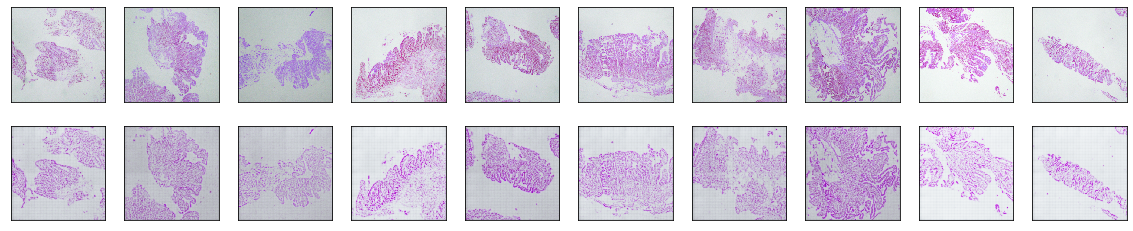

(20, 256, 256, 3)


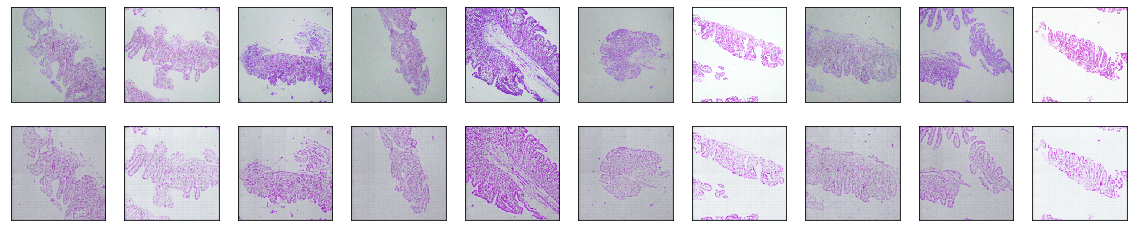

(20, 256, 256, 3)


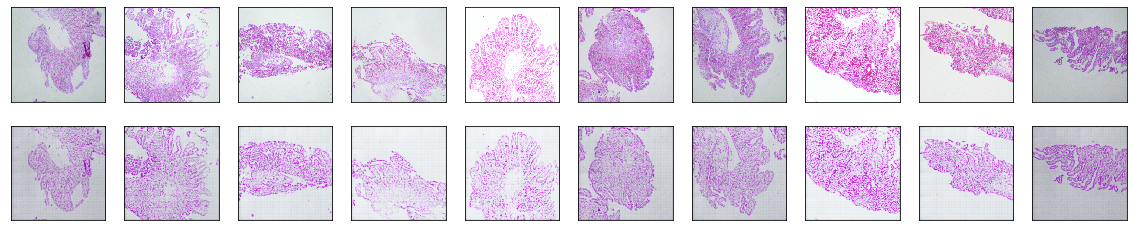

In [ ]:
visualizer(X_train , vae)
visualizer(X_valid , vae)
visualizer(X_test , vae)